# TIME SERIES FORECASTING

In [ ]:
#importing the necessary libraries
import os  #working directory
import pandas as pd  #data processing
import numpy as np   #data processing
import matplotlib.pyplot as plt  #visualization
import seaborn as sns            #visualization
import pmdarima as pm       #applyling ARIMA
from pmdarima.arima.utils import ndiffs  #stationarity/differencing
from numpy import log   #stationarity
from statsmodels.tsa.stattools import adfuller  #stationarity
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf  #ACF and PACF plots
import statsmodels.api as sm  #forecasting

In [ ]:
import warnings  #ensure no warnings are displayed
warnings.filterwarnings('ignore')

# FORECASTING OFFICE SUPPLIES SALES FOR THE RETAIL STORE

In [ ]:
os.chdir(R'C:\Users\TANIA DAS\Downloads')   #setting the working directory
df=pd.read_excel('Superstore_Office_Supplies.xls')  #loading the xls data

Data is imported successfully.

In [ ]:
ofc_superstore=df[df['Category']=='Office Supplies']  #Filtering out the data only for office supplies since, i will be forecasting office supplies sales
display(ofc_superstore.head())  #getting the first 5 rows of the filtered data frame

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.620,2,0.0,6.8714
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.368,2,0.2,2.5164
6,7,CA-2014-115812,2014-06-09,2014-06-14,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,OFF-AR-10002833,Office Supplies,Art,Newell 322,7.280,4,0.0,1.9656
8,9,CA-2014-115812,2014-06-09,2014-06-14,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,OFF-BI-10003910,Office Supplies,Binders,DXL Angle-View Binders with Locking Rings by S...,18.504,3,0.2,5.7825
9,10,CA-2014-115812,2014-06-09,2014-06-14,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,OFF-AP-10002892,Office Supplies,Appliances,Belkin F5C206VTEL 6 Outlet Surge,114.900,5,0.0,34.4700


In [ ]:
print(ofc_superstore['Order Date'].min())
print(ofc_superstore['Order Date'].max())

2014-01-03 00:00:00
2017-12-30 00:00:00


We have 4 years of data for office supplies in our dataset, which is sufficient enough.

In [ ]:
#checking for missing values if any
ofc_superstore.isnull().sum()

Row ID           0
Order ID         0
Order Date       0
Ship Date        0
Ship Mode        0
Customer ID      0
Customer Name    0
Segment          0
Country          0
City             0
State            0
Postal Code      0
Region           0
Product ID       0
Category         0
Sub-Category     0
Product Name     0
Sales            0
Quantity         0
Discount         0
Profit           0
dtype: int64

Our data set has no missing values.

In [ ]:
#arranging the data chronologically
ofc_superstore = ofc_superstore.groupby('Order Date')['Sales'].sum().reset_index()

In [ ]:
#indexing with time series
ofc_superstore = ofc_superstore.set_index('Order Date')

In [ ]:
#working at the average monthly sales
z=ofc_superstore['Sales'].resample('MS').mean()

In [ ]:
z1=z.reset_index()
z1.columns

Index(['Order Date', 'Sales'], dtype='object')

Text(0, 0.5, 'SALES')

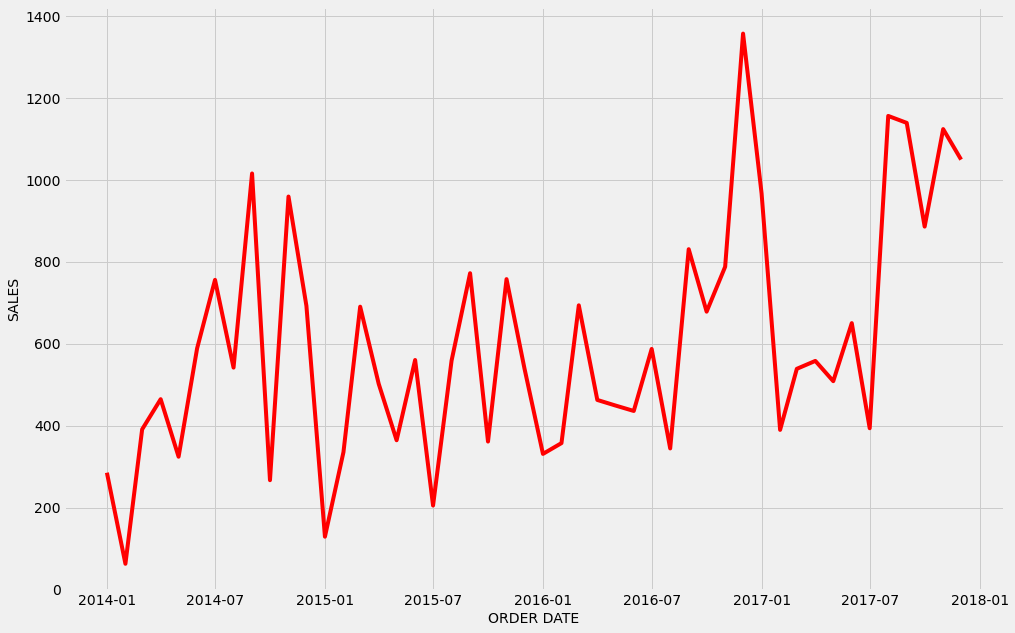

In [ ]:
plt.figure(figsize=(15,10))
plt.plot(z1['Order Date'],z1['Sales'],color='red')
plt.xlabel('ORDER DATE',fontdict={'color':'black','size':14})
plt.ylabel('SALES',fontdict={'color':'black','size':14})

### Decomposing the Data: Trend, Seasonal and Irregular Component

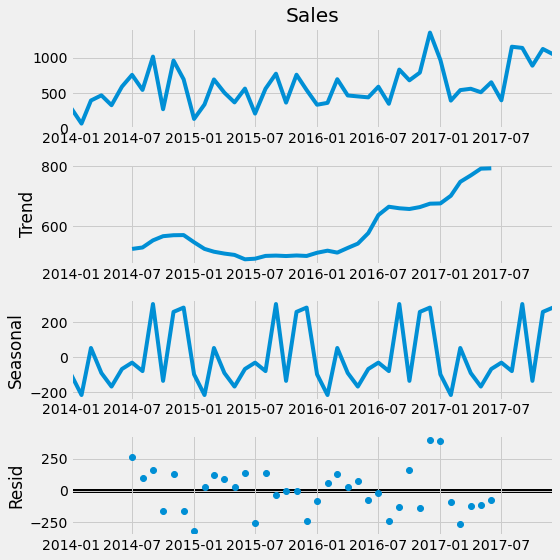

In [ ]:
from pylab import rcParams
rcParams['figure.figsize'] = 8, 8
decomposition=sm.tsa.seasonal_decompose(z,model='additive')
fig=decomposition.plot()

## Checking the stationarity of the model

Text(0.5, 1.0, 'AUTOCORRELATION')

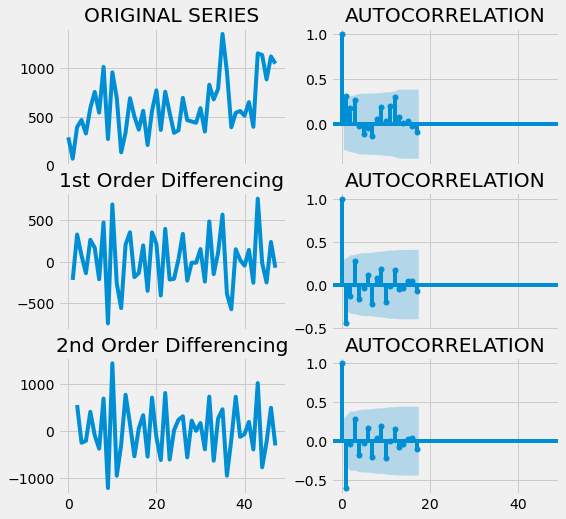

In [ ]:
plt.style.use('fivethirtyeight')
fig,axes=plt.subplots(3,2,sharex=True)
axes[0,0].plot(z1['Sales'])
axes[0,0].set_title('ORIGINAL SERIES')
plot_acf(z1['Sales'],ax=axes[0,1])
axes[0,1].set_title('AUTOCORRELATION')

axes[1,0].plot(z1['Sales'].diff())
axes[1,0].set_title('1st Order Differencing')
plot_acf(z1['Sales'].diff().dropna(),ax=axes[1,1])
axes[1,1].set_title('AUTOCORRELATION')

axes[2,0].plot(z1['Sales'].diff().diff())
axes[2,0].set_title('2nd Order Differencing')
plot_acf(z1['Sales'].diff().diff().dropna(),ax=axes[2,1])
axes[2,1].set_title('AUTOCORRELATION')

### ADF Test

In [ ]:
stat=adfuller(z1['Sales'].diff().dropna())
print('ADF Statistic: %f' % stat[0])
print('p-value: %f' % stat[1])

ADF Statistic: -8.603123
p-value: 0.000000


Since the p-value<=0.05,we can say that the data has achieved stationary at first order differencing.

## Finding the AR term of model

Text(0.5, 1.0, 'PARTIAL AUTOCORRELATION')

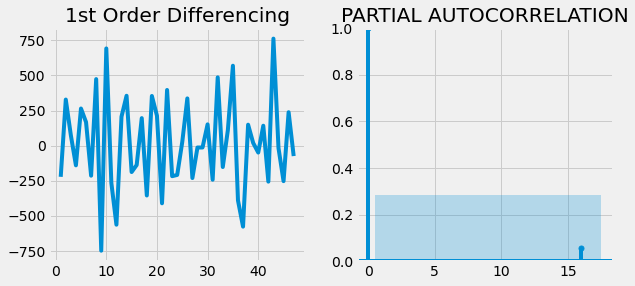

In [ ]:
rcParams['figure.figsize']=9,4
fig,axes=plt.subplots(1,2)
axes[0].plot(z1['Sales'].diff().dropna())
axes[0].set_title('1st Order Differencing')
axes[1].set(ylim=(0,1))
plot_pacf(z1['Sales'].diff().dropna(),ax=axes[1])
axes[1].set_title('PARTIAL AUTOCORRELATION')

## Finding the MA term of model

Text(0.5, 1.0, 'AUTOCORRELATION')

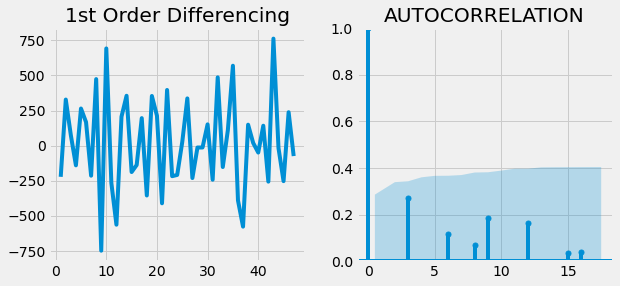

In [ ]:
rcParams['figure.figsize']=9,4
fig,axes=plt.subplots(1,2)
axes[0].plot(z1['Sales'].diff().dropna())
axes[0].set_title('1st Order Differencing')
axes[1].set(ylim=(0,1))
plot_acf(z1['Sales'].diff().dropna(),ax=axes[1])
axes[1].set_title('AUTOCORRELATION')

## Time Series Forecasting using SARIMA

Seasonal Autoregressive Integrated Moving Average, SARIMA or Seasonal ARIMA, is an extension of ARIMA that explicitly supports univariate time series data with a seasonal component.

SARIMA requires selecting hyperparameters for both the trend and seasonal elements of the series.

Trend Elements There are three trend elements that require configuration. p: Trend autoregression order. d: Trend difference order. q: Trend moving average order.

Seasonal Elements There are four seasonal elements: P: Seasonal autoregressive order. D: Seasonal difference order. Q: Seasonal moving average order. m: The number of time steps for a single seasonal period.

The notation for a SARIMA model is specified as: SARIMA(p,d,q)(P,D,Q,m)

In [ ]:
import itertools
p=q=range(0,3)
d=range(1,2)
for i in itertools.product(p,d,q):
    print(i)

(0, 1, 0)
(0, 1, 1)
(0, 1, 2)
(1, 1, 0)
(1, 1, 1)
(1, 1, 2)
(2, 1, 0)
(2, 1, 1)
(2, 1, 2)


In [ ]:
pdq=list(itertools.product(p,d,q))

In [ ]:
seasonal_pdq=[(j[0],j[1],j[2],12)for j in list(itertools.product(p,d,q))]

In [ ]:
for order1 in pdq: #for loop for determining the best combination of seasonal parameters for SARIMA
    for seasonal_order1 in seasonal_pdq:

            mod = sm.tsa.statespace.SARIMAX(z,
                                            order=order1,
                                            seasonal_order=seasonal_order1,
                                            enforce_stationarity=False,# Not Enforcing Stationarity,
                                            enforce_invertibility=False)#Models do converge, Model is estimatble
            results = mod.fit()
            pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
            pred_ci = pred.conf_int()
            y_forecasted = pred.predicted_mean
            y_truth = z['2017-01-01':]
            mape = np.mean(np.abs(y_forecasted - y_truth)/np.abs(y_truth))
            print('SARIMAX{}x{} - mape:{}'.format(order1, seasonal_order1,mape))


SARIMAX(0, 1, 0)x(0, 1, 0, 12) - mape:0.5023493154704108
SARIMAX(0, 1, 0)x(0, 1, 1, 12) - mape:0.35754349619465825
SARIMAX(0, 1, 0)x(0, 1, 2, 12) - mape:0.3380546826619717
SARIMAX(0, 1, 0)x(1, 1, 0, 12) - mape:0.3286692157555934
SARIMAX(0, 1, 0)x(1, 1, 1, 12) - mape:0.3389582882777112
SARIMAX(0, 1, 0)x(1, 1, 2, 12) - mape:0.40148198289969733
SARIMAX(0, 1, 0)x(2, 1, 0, 12) - mape:0.3538307524613274
SARIMAX(0, 1, 0)x(2, 1, 1, 12) - mape:0.3537625457883906
SARIMAX(0, 1, 0)x(2, 1, 2, 12) - mape:0.40497385795186047
SARIMAX(0, 1, 1)x(0, 1, 0, 12) - mape:0.33720268786876223
SARIMAX(0, 1, 1)x(0, 1, 1, 12) - mape:0.27338732776748614
SARIMAX(0, 1, 1)x(0, 1, 2, 12) - mape:0.26981254975947505
SARIMAX(0, 1, 1)x(1, 1, 0, 12) - mape:0.2748679908665953
SARIMAX(0, 1, 1)x(1, 1, 1, 12) - mape:0.28684343191121864
SARIMAX(0, 1, 1)x(1, 1, 2, 12) - mape:0.33252296790054947
SARIMAX(0, 1, 1)x(2, 1, 0, 12) - mape:0.2537545531984278
SARIMAX(0, 1, 1)x(2, 1, 1, 12) - mape:0.2636944040580534
SARIMAX(0, 1, 1)x(2, 1,

The above outut suggests that SARIMAX(2,1,1)x(2,1,2,12) yields the lowest mean absolute percentage error (MAPE) of 0.19962620074089552 .Therefore we should consider this to be the optimal option.

## Fitting the SARIMA model

In [ ]:
mod = sm.tsa.statespace.SARIMAX(z,
                                order=(2,1,1),
                                seasonal_order=(2, 1, 2, 12),
                                enforce_stationarity=False,# Not Enforcing Stationarity,
                                enforce_invertibility=False)#Models do converge, Model is estimatble
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0489      0.804      0.061      0.951      -1.526       1.624
ar.L2         -0.3049      0.550     -0.555      0.579      -1.382       0.772
ma.L1          0.5536      1.523      0.364      0.716      -2.431       3.538
ar.S.L12      -1.2831      1.346     -0.953      0.340      -3.921       1.354
ar.S.L24       0.0061      2.340      0.003      0.998      -4.580       4.592
ma.S.L12       1.3389      1.658      0.808      0.419      -1.911       4.588
ma.S.L24      -0.1239      1.324     -0.094      0.925      -2.720       2.472
sigma2      4454.4026      0.000   1.02e+07      0.000    4454.402    4454.403


### Validating the forecast

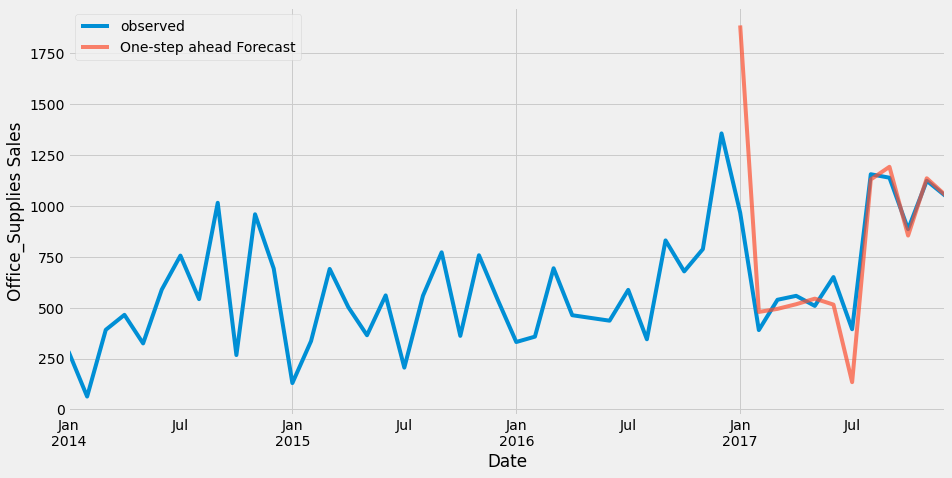

In [ ]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = z['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.set_xlabel('Date')
ax.set_ylabel('Office_Supplies Sales')
plt.legend()

In [ ]:
y_forecasted = pred.predicted_mean
y_truth = z['2017-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))


The Mean Squared Error of our forecasts is 79312.48
The Root Mean Squared Error of our forecasts is 281.62


Smaller the MSE closer we are to the best fit line.

### Diagnostic Checking

In [ ]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # Mean Absolute Percentage Error
    me = np.mean(forecast - actual)             # Mean Error
    mae = np.mean(np.abs(forecast - actual))    # Mean Absolute Error
    mpe = np.mean((forecast - actual)/actual)   # Mean Percentage Error
    rmse = np.mean((forecast - actual)**2)**.5  # Root Mean Squared Error
    corr = np.corrcoef(forecast, actual)[0,1]   # correlation
    mins = np.amin(np.hstack([forecast[:,None],
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None],
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax

    return({'mape':mape, 'me':me, 'mae': mae,
            'mpe': mpe, 'rmse':rmse,
            'corr':corr, 'minmax':minmax})

forecast_accuracy=forecast_accuracy(y_forecasted, y_truth)
display(forecast_accuracy)

{'mape': 0.19962620074089552,
 'me': 48.07569655112223,
 'mae': 137.81883631916847,
 'mpe': 0.019151199241665518,
 'rmse': 281.62471353775345,
 'corr': 0.8116685158940926,
 'minmax': 0.15679336630191232}

Since all of the values are low we can say our forecasting model is good.

## Producing And Visualizing Forecasts

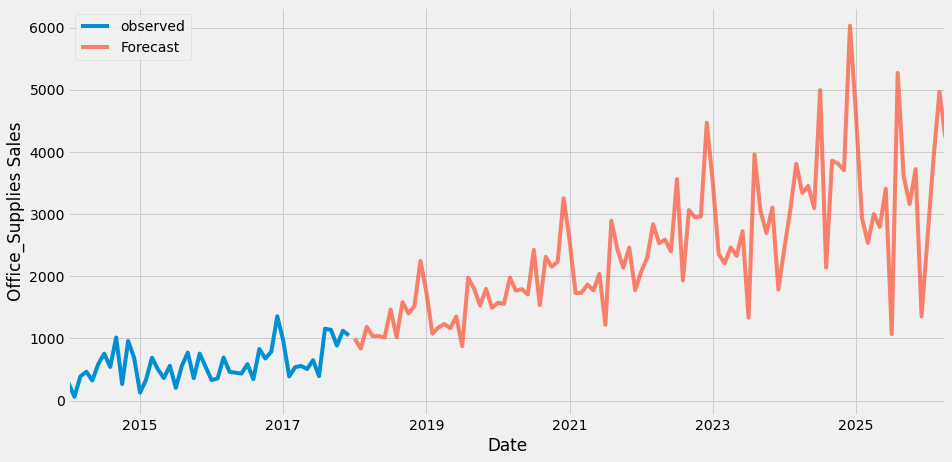

In [ ]:
pred1 = results.get_forecast(steps=100)
pred_ci1 = pred.conf_int()
ax = z.plot(label='observed')
pred1.predicted_mean.plot(ax=ax, label= 'Forecast', alpha=.7, figsize=(14, 7))
ax.set_xlabel('Date')
ax.set_ylabel('Office_Supplies Sales')
plt.legend()